![picture](https://doc.google.com/uc?id=1-SCmtVCHxEXXpBfRMwvY_gBrDFA6Pb3u)
# **The Vehicle Type Classification Project**

## Evaluation of the classifier

We first need to load the required libraries


In [1]:
%load_ext autoreload
%autoreload 2

# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, BatchNormalization
#from tensorflow.keras.applications import Xception
#from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import sys
import tensorflow as tf
import h5py
import numpy as np
import sys

In [2]:
#set the model type that you will train in this notebook
TYPE='type'
model_type='mobilenetv2'
#set your user name
user='anis'
iteration='2'

#NOTE: Make sure to set the correct project path with respect to your Google Drive

PROJECT_PATH='/content/drive/My Drive/udemy-deep-learning-in-practice/03-transfer-learning/03-train-models/'
print('PROJECT_PATH: ',PROJECT_PATH)

HDF5_DATASET_PATH=PROJECT_PATH+'datasets/vehicle-type-dataset-SIZE224-train-dev-test-v2.hdf5'
print('HDF5_DATASET_PATH: ', HDF5_DATASET_PATH)

ACCURACY_LOSS_OUPUT_FILE=PROJECT_PATH+'log/'+model_type+'/'+model_type+'-by-'+TYPE+'-accuracy-loss-'+user+'-'+iteration+'.jpg'
print('ACCURACY_LOSS_OUPUT_FILE: ', ACCURACY_LOSS_OUPUT_FILE)

TRAINED_MODEL=PROJECT_PATH+'trained-models/'+model_type+'/'+'vehicle-classification-by-'+TYPE+'-'+model_type+'-'+user+'-'+iteration+'.h5'
print('TRAINED_MODEL: ',TRAINED_MODEL)

CHECKPOINT_PATH = PROJECT_PATH+'checkpoints/'+model_type+'/'+'by-'+TYPE+'-'+model_type+'-'+user+'-'+iteration+'.h5'
print('CHECKPOINT_PATH: ',CHECKPOINT_PATH)

LOGFILE_PATH=PROJECT_PATH+'log/'+model_type+'/'+model_type+'-by-'+TYPE+'-training-log'+user+'-'+iteration+'.csv'
print('LOGFILE_PATH: ',LOGFILE_PATH)


PROJECT_PATH:  /content/drive/My Drive/udemy-deep-learning-in-practice/03-transfer-learning/03-train-models/
HDF5_DATASET_PATH:  /content/drive/My Drive/udemy-deep-learning-in-practice/03-transfer-learning/03-train-models/datasets/vehicle-type-dataset-SIZE224-train-dev-test-v2.hdf5
ACCURACY_LOSS_OUPUT_FILE:  /content/drive/My Drive/udemy-deep-learning-in-practice/03-transfer-learning/03-train-models/log/mobilenetv2/mobilenetv2-by-type-accuracy-loss-anis-2.jpg
TRAINED_MODEL:  /content/drive/My Drive/udemy-deep-learning-in-practice/03-transfer-learning/03-train-models/trained-models/mobilenetv2/vehicle-classification-by-type-mobilenetv2-anis-2.h5
CHECKPOINT_PATH:  /content/drive/My Drive/udemy-deep-learning-in-practice/03-transfer-learning/03-train-models/checkpoints/mobilenetv2/by-type-mobilenetv2-anis-2.h5
LOGFILE_PATH:  /content/drive/My Drive/udemy-deep-learning-in-practice/03-transfer-learning/03-train-models/log/mobilenetv2/mobilenetv2-by-type-training-loganis-2.csv


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
sys.path.append(PROJECT_PATH)
import anis_koubaa_udemy_computer_vision_lib  
from anis_koubaa_udemy_computer_vision_lib import *

# **Load the Dataset**

In [5]:
def load_dataset_from_hdf5_file(hdf_file_path):
  hf = h5py.File(hdf_file_path, "r")
  trainX= np.array(hf["trainX"]).astype("f8")
  ascii_train_labels = np.array(hf["trainLabels"]).astype("S65")
  trainY=np.array(hf["trainY"]).astype("int")

  devX= np.array(hf["devX"]).astype("f8")
  ascii_dev_labels = np.array(hf["devLabels"]).astype("S65")
  devY=np.array(hf["devY"]).astype("int")

  testX= np.array(hf["testX"]).astype("f8")
  ascii_test_labels = np.array(hf["testLabels"]).astype("S65")
  testY=np.array(hf["testY"]).astype("int")

  trainLabels = np.array([n.decode('unicode_escape') for n in ascii_train_labels])
  devLabels = np.array([n.decode('unicode_escape') for n in ascii_dev_labels])
  testLabels = np.array([n.decode('unicode_escape') for n in ascii_test_labels])

  print("trainX.shape: ",trainX.shape)
  print("trainY.shape: ",trainY.shape)
  print("trainLabels.shape: ",trainLabels.shape)
  print("devX.shape: ",devX.shape)
  print("devY.shape: ",devY.shape)
  print("devLabels.shape: ",devLabels.shape)
  print("testX.shape: ",testX.shape)
  print("testY.shape: ",testY.shape)
  print("testLabels.shape: ",testLabels.shape)

  return trainX, trainY, trainLabels, devX,devY,devLabels,testX,testY,testLabels

In [6]:
def load_dev_test_dataset_from_hdf5_file(hdf_file_path):
  hf = h5py.File(hdf_file_path, "r")

  devX= np.array(hf["devX"]).astype("f8")
  ascii_dev_labels = np.array(hf["devLabels"]).astype("S65")
  devY=np.array(hf["devY"]).astype("int")

  testX= np.array(hf["testX"]).astype("f8")
  ascii_test_labels = np.array(hf["testLabels"]).astype("S65")
  testY=np.array(hf["testY"]).astype("int")


  devLabels = np.array([n.decode('unicode_escape') for n in ascii_dev_labels])
  testLabels = np.array([n.decode('unicode_escape') for n in ascii_test_labels])


  print("devX.shape: ",devX.shape)
  print("devY.shape: ",devY.shape)
  print("devLabels.shape: ",devLabels.shape)
  print("testX.shape: ",testX.shape)
  print("testY.shape: ",testY.shape)
  print("testLabels.shape: ",testLabels.shape)

  return devX,devY,devLabels,testX,testY,testLabels

In [7]:
import datetime
t0 = datetime.datetime.now()
devX,devY,devLabels,testX,testY,testLabels=load_dev_test_dataset_from_hdf5_file(HDF5_DATASET_PATH)
t1 = datetime.datetime.now()
print('time to load data: ', (t1-t0))

devX.shape:  (75, 224, 224, 3)
devY.shape:  (75, 7)
devLabels.shape:  (75,)
testX.shape:  (76, 224, 224, 3)
testY.shape:  (76, 7)
testLabels.shape:  (76,)
time to load data:  0:00:03.000054


In [8]:
IMAGE_SIZE=testX.shape[1]
print(IMAGE_SIZE)

224


# **Dataset Visualization**

In [9]:
#anis_koubaa_udemy_computer_vision_lib.plot_sample_from_dataset(trainX, trainLabels,rows=2, colums=5, width=20,height=8)


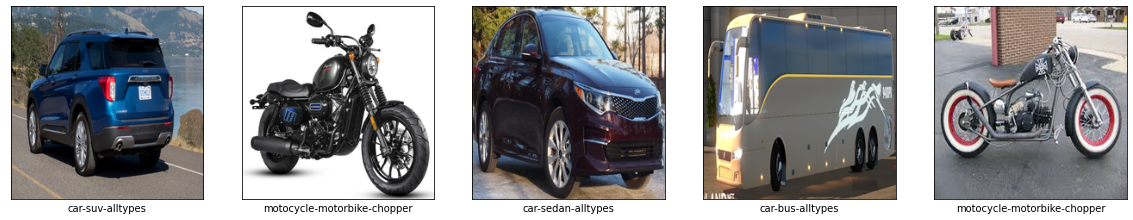

In [10]:
anis_koubaa_udemy_computer_vision_lib.plot_sample_from_dataset(devX, devLabels,rows=1, colums=5, width=20,height=8)

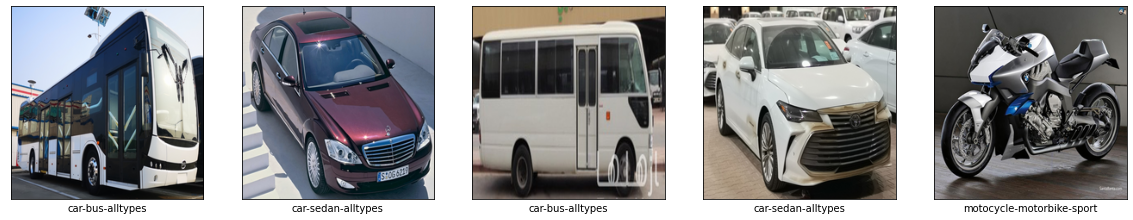

In [11]:
anis_koubaa_udemy_computer_vision_lib.plot_sample_from_dataset(testX, testLabels,rows=1, colums=5, width=20,height=8)

In [12]:
# Convert to TF Serving

In [13]:
#print('Loading the best model...')
#model = tf.keras.models.load_model(CHECKPOINT_PATH)

In [14]:
#tf.compat.v1.keras.experimental.export_saved_model(model, PROJECT_PATH+'tensorflow-serving-models-by-147-generation-98')

# **Make Predictions**

In [41]:
print('Loading the best model...', TRAINED_MODEL)
t0 = datetime.datetime.now()
test_model = tf.keras.models.load_model(CHECKPOINT_PATH)
t1 = datetime.datetime.now()
print('time to load the model: ', (t1-t0))

Loading the best model... /content/drive/My Drive/udemy-deep-learning-in-practice/03-transfer-learning/03-train-models/trained-models/mobilenetv2/vehicle-classification-by-type-mobilenetv2-anis-2.h5
time to load the model:  0:00:01.004616


In [42]:
# make predictions on the testing set
print("[INFO] evaluating network on the dev dataset...")
test_model.evaluate(devX, devY,verbose=0)



[INFO] evaluating network on the dev dataset...


[1.2683249711990356, 0.9733333587646484]

In [43]:
print("[INFO] evaluating network on the test dataset...")
test_model.evaluate(testX, testY,verbose=0)

[INFO] evaluating network on the test dataset...


[1.2826839685440063, 0.9605262875556946]

In [18]:
class_dict,number_of_classes=get_cars_classes_dict(testY,testLabels)
class_dict

{0: 'car-bus-alltypes',
 1: 'car-sedan-alltypes',
 2: 'car-suv-alltypes',
 3: 'motocycle-bicycle-kids',
 4: 'motocycle-bicycle-racing',
 5: 'motocycle-motorbike-chopper',
 6: 'motocycle-motorbike-sport'}

In [19]:
class_dict[6]

'motocycle-motorbike-sport'

In [20]:
len(class_dict)

7

In [21]:
len(class_dict)

7

# **Testing on one image**

[0 0 0 0 0 0 1]
motocycle-motorbike-sport
Label = motocycle-motorbike-sport
image shape:  (224, 224, 3)


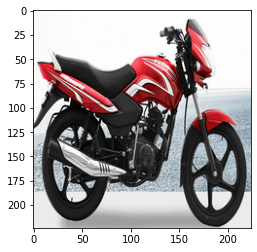

In [22]:
index=30
test_image = testX[index]
print(testY[index])
print(class_dict[np.argmax(testY[index])])
anis_koubaa_udemy_computer_vision_lib.display_image(testX, testLabels, index)


In [23]:
import datetime


flatten the image
image.shape (150528, 1)
reshape the image to be similar to the input feature vector
image.shape (1, 224, 224, 3)
-----------------------------------------
prediction time:  0:00:00.665586
true label:  [0 0 0 0 0 0 1]
predicted label:  6
Car Brand:  motocycle-motorbike-sport
Car Brand Predicted:  motocycle-motorbike-sport
Confidence:  0.69725376
-----------------------------------------


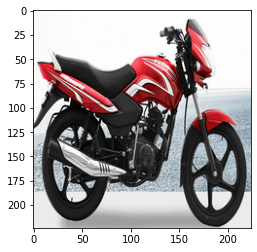

In [24]:
plt.imshow(test_image)
reshaped_image=anis_koubaa_udemy_computer_vision_lib.reshape_image_for_neural_network_input(test_image,IMAGE_SIZE=224, 
                                                                                   normalize=False)#must be false because already normalized

t0 = datetime.datetime.now()
prediction_array = test_model.predict(reshaped_image)
t1 = datetime.datetime.now()
print('-----------------------------------------')
print ("prediction time: ", t1-t0)
print ("true label: ", testY[index])
print ("predicted label: ", np.argmax(prediction_array[0]))
print ("Car Brand: ",class_dict[np.argmax(testY[index])])
print ("Car Brand Predicted: ",class_dict[np.argmax(prediction_array[0])])
print ("Confidence: ",prediction_array[0][np.argmax(prediction_array[0])])
print('-----------------------------------------')


In [25]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predicted_label = np.argmax(testY[index])
print("true label: ", np.argmax(prediction_array[0]))
print("predicted label: ", predicted_label)

true label:  6
predicted label:  6


In [26]:
reshaped_test_image = anis_koubaa_udemy_computer_vision_lib.reshape_image_for_neural_network_input(testX[index], IMAGE_SIZE=224,normalize=False)
p = test_model.predict(reshaped_test_image)
print(p)
class_dict[np.argmax(p[0])]

flatten the image
image.shape (150528, 1)
reshape the image to be similar to the input feature vector
image.shape (1, 224, 224, 3)
[[0.01968887 0.00077325 0.00328304 0.00655423 0.00221232 0.27023447
  0.69725376]]


'motocycle-motorbike-sport'

# **Testing with the whole dataset**

In [27]:
prediction_array_all_test_dataset = test_model.predict(testX, verbose=1)
predicted_labels_all_test_dataset = np.argmax(prediction_array_all_test_dataset, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predicted_labels_all_test_dataset,target_names=np.unique(testLabels)))

3/3 [==============================] - 0s 19ms/step
                             precision    recall  f1-score   support

           car-bus-alltypes       1.00      1.00      1.00        13
         car-sedan-alltypes       0.92      1.00      0.96        12
           car-suv-alltypes       1.00      0.89      0.94         9
     motocycle-bicycle-kids       0.93      1.00      0.96        13
   motocycle-bicycle-racing       1.00      0.80      0.89        10
motocycle-motorbike-chopper       0.90      1.00      0.95         9
  motocycle-motorbike-sport       1.00      1.00      1.00        10

                   accuracy                           0.96        76
                  macro avg       0.96      0.96      0.96        76
               weighted avg       0.96      0.96      0.96        76



In [28]:
# accuracy, sensitivity, and specificity
model_confusion_matrix = confusion_matrix(testY.argmax(axis=1), predicted_labels_all_test_dataset)
print("model_confusion_matrix: \n",model_confusion_matrix)


model_confusion_matrix: 
 [[13  0  0  0  0  0  0]
 [ 0 12  0  0  0  0  0]
 [ 0  1  8  0  0  0  0]
 [ 0  0  0 13  0  0  0]
 [ 0  0  0  1  8  1  0]
 [ 0  0  0  0  0  9  0]
 [ 0  0  0  0  0  0 10]]


In [29]:
#anis_koubaa_udemy_computer_vision_lib.plot_loss_accuracy(H,EPOCHS=25, output_file=ACCURACY_LOSS_OUPUT_FILE)

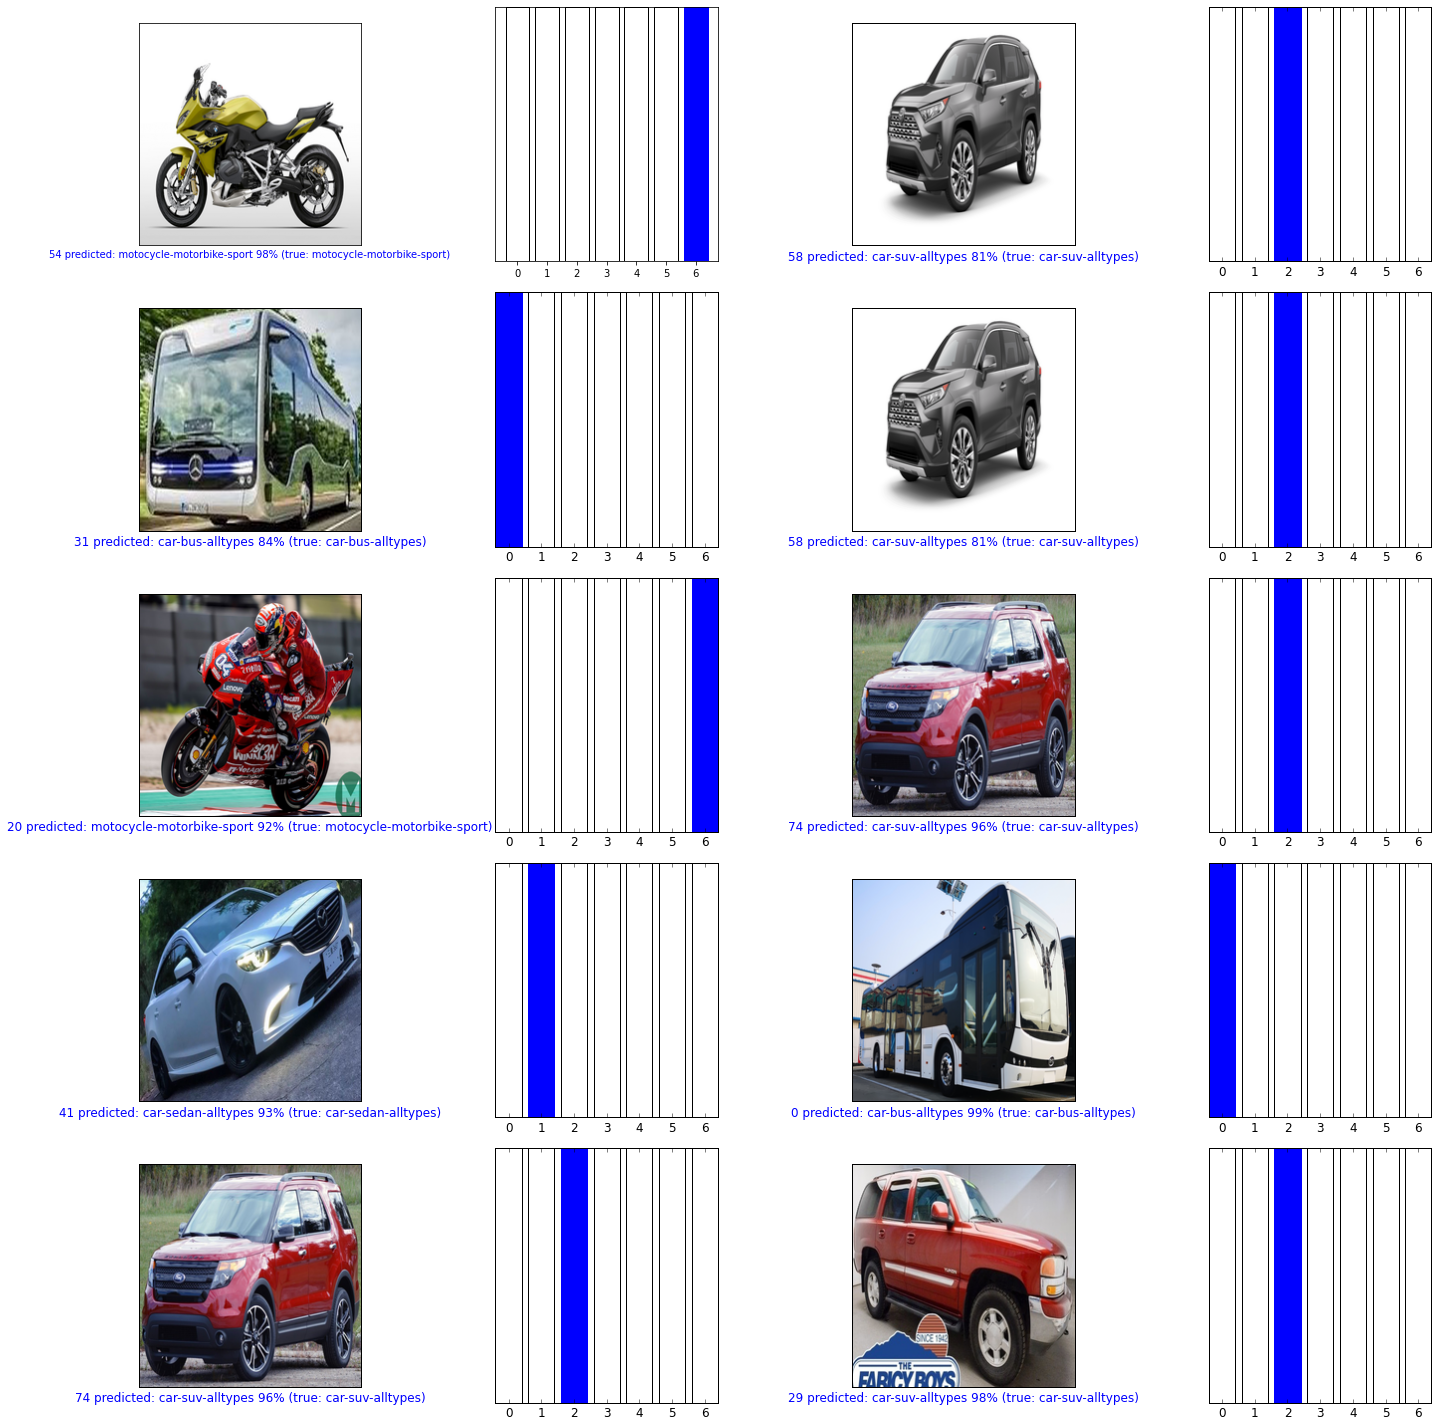

In [30]:
#classes_names=['covid', 'normal']
#print(testX.shape)
#print(test_binary_labels.shape)
#anis_koubaa_udemy_computer_vision_lib.plot_car_sample_predictions(testX, prediction_array_all_test_dataset, testY, number_of_classes=42, num_rows = 20, num_cols = 1, width=30, height=40,is_random=True)
anis_koubaa_udemy_computer_vision_lib.plot_car_sample_predictions_v2(testX, testY, testLabels, prediction_array_all_test_dataset, num_rows = 5, num_cols = 2, width=20, height=20, is_random=True, plot_bars=True)

None
(224, 224)
RGB
(224, 224, 3)
(224, 224, 3)


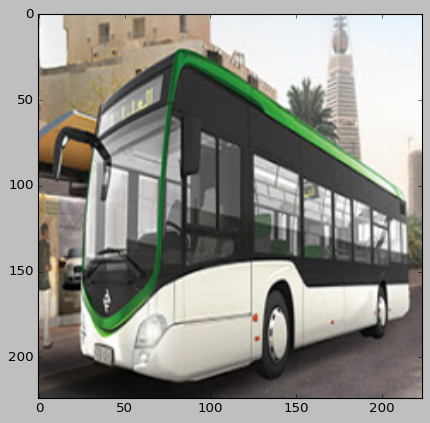

In [31]:
from PIL import Image
test_image = Image.open(PROJECT_PATH+'test-images/bus.jpg')

IMAGE_SIZE=224

test_image = test_image.resize((IMAGE_SIZE, IMAGE_SIZE))

print(test_image.format)
print(test_image.size)
print(test_image.mode)
test_image = np.array(test_image)
print (test_image.shape)
if (test_image.shape[2]>3): #sometime the image comes with RGBA with 4 channels
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGRA2BGR)
print (test_image.shape)
x=plt.imshow(test_image)

In [32]:
reshaped_test_image = anis_koubaa_udemy_computer_vision_lib.reshape_image_for_neural_network_input(test_image, IMAGE_SIZE=224,normalize=True)
prediction_my_image = test_model.predict(reshaped_test_image)
print(prediction_my_image)
class_dict[np.argmax(prediction_my_image)]


flatten the image
image.shape (150528, 1)
reshape the image to be similar to the input feature vector
image.shape (1, 224, 224, 3)
[[0.9447204  0.00811246 0.00346715 0.01328979 0.01628393 0.00966704
  0.00445917]]


'car-bus-alltypes'

In [33]:
def top_five(prediction_my_image, class_dict):
    sorted_array=np.argsort(prediction_my_image)[0][-5:]
    sorted_array=np.flip(sorted_array)
    sorted_array
    for s in sorted_array:
    #print(class_dict[s])
    #print('id:',s,', brand:'+class_dict[s]+', confidence:',prediction_my_image[0,s])
        print('id: %3d, brand:%-10s, confidence: %6.3f'%(s,class_dict[s],prediction_my_image[0,s]))

In [34]:
top_five(prediction_my_image, class_dict)

id:   0, brand:car-bus-alltypes, confidence:  0.945
id:   4, brand:motocycle-bicycle-racing, confidence:  0.016
id:   3, brand:motocycle-bicycle-kids, confidence:  0.013
id:   5, brand:motocycle-motorbike-chopper, confidence:  0.010
id:   1, brand:car-sedan-alltypes, confidence:  0.008


number of misclassications:  3
number of images: 75
rate of misclassications:  4.0 %
{6: ['motocycle-bicycle-racing', 'motocycle-motorbike-chopper'], 40: ['car-suv-alltypes', 'car-sedan-alltypes'], 46: ['motocycle-bicycle-racing', 'motocycle-bicycle-kids']}


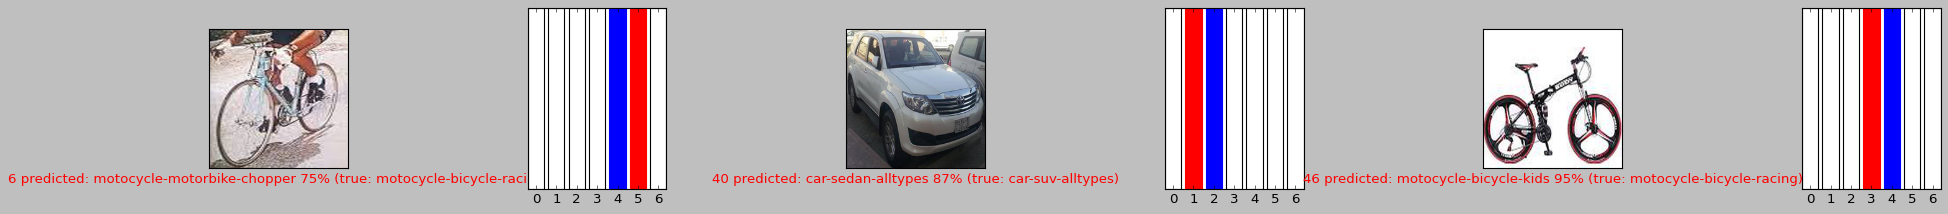

time to find misclassifications:  0:00:00.513404


In [35]:
t0=datetime.datetime.now()
ms_test=anis_koubaa_udemy_computer_vision_lib.plot_misclassifications(testX, testY, testLabels, prediction_array_all_test_dataset, num_rows =15 , num_cols=5, width=40, height=40, is_random=False, plot_bars=True)
t1=datetime.datetime.now()
print('time to find misclassifications: ',(t1-t0))

In [36]:
prediction_array_all_dev_dataset = test_model.predict(devX, verbose=1)

3/3 [==============================] - 0s 19ms/step


number of misclassications:  2
number of images: 75
rate of misclassications:  2.6666666666666665 %
{1: ['motocycle-motorbike-chopper', 'motocycle-motorbike-sport'], 53: ['car-suv-alltypes', 'car-sedan-alltypes']}


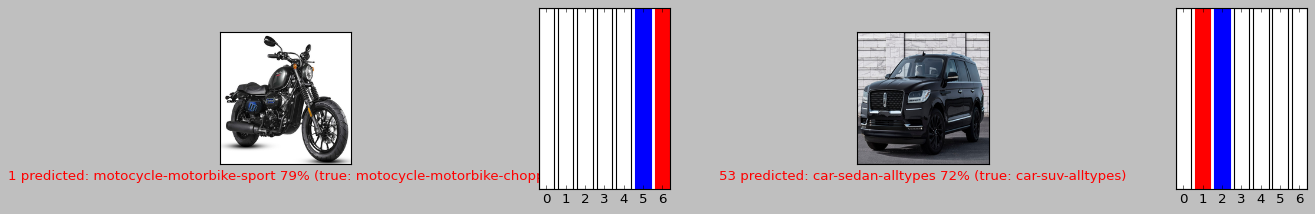

time to find misclassifications:  0:00:00.301496


In [37]:

t0=datetime.datetime.now()
ms_dev=anis_koubaa_udemy_computer_vision_lib.plot_misclassifications(devX, devY, devLabels, prediction_array_all_dev_dataset, num_rows =15 , num_cols=5, width=40, height=40, is_random=False, plot_bars=True)
t1=datetime.datetime.now()
print('time to find misclassifications: ',(t1-t0))